# Readout of photoelectron momentum distributions datasets

Tomasz Szoldra, 2023

### Datasets can be freely downloaded from the *[OpenData catalog](https://chaos.if.uj.edu.pl/ZOA/index.php?which=opendata&dataset=/2303.13940)*

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import matplotlib as mpl
from skimage.transform import resize

All datasets contain photoelectron momentum distributions for Argon target. 
In each case, frequency $\omega = 0.057$ and the ionization potential $I_p = 0.579$ in atomic units.

The QProp dataset alltogether contains 15712 PMDs.
The SFA dataset is calculated for a randomly chosen subset of 1000 parameters in the QProp dataset.

All datasets are numpy archives *.npz. Examples how to read them are in the 01_dataset_readout.ipynb notebook.
Each archive contains a set of numpy arrays
- `PDFs` - contains 2D momentum probability distribution; axes correspond to (realization_idx, pz, px)
- `labels` - axes correspond to 
    - QProp: (realization_idx, [Up N CEP]).
	- SFA: (realization_idx, [Ip Up omega N CEP Target])
	- Experiment: (realization_idx, [Up])
- `grid` - contains pairs [pz, px]; axes correspond to (pz, px) in PDFs

In [8]:
path = '../../public_dataset/data_preprocessed/Qprop/QProp_Ar_FA+CA.npz'

In [9]:
npz = np.load(path)

In [10]:
npz.files

['PDFs', 'labels', 'grid']

In [11]:
PDFs = npz['PDFs']
labels = npz['labels']
grid = npz['grid']

In [62]:
PDFs.shape

(3071, 468, 233)

In [63]:
labels.shape

(3071, 3)

In [64]:
grid.shape

(468, 233, 2)

In [65]:
def get_idx_close_to(labels, Up, N=None, tolerance_Up=0.01, tolerance_N=1):
    if N is not None:
        idx = np.where(
            np.logical_and(
                np.abs(labels[:, 0] - Up) <= tolerance_Up, 
                np.abs(labels[:, 1] - N) <= tolerance_N))[0][0]
    else:
        idx = np.where(np.abs(labels[:, 0] - Up) <= tolerance_Up)[0][0]
    return idx

In [66]:
sample_idx = get_idx_close_to(labels, 0.35, N=40)

In [67]:
sample_idx

1088

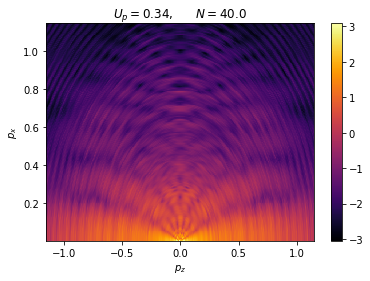

In [68]:
plt.pcolormesh(grid[:, :, 0], grid[:, :, 1], np.log10(PDFs[sample_idx]), cmap='inferno')
plt.xlabel('$p_z$')
plt.ylabel('$p_x$')
plt.title(f"$U_p={labels[sample_idx, 0]}$,\t $N={labels[sample_idx, 1]}$")
plt.colorbar()
plt.show()

## What if I want to use my own dataset with your models?

The models were trained on the PMDs for the following photoelectron momentum grid

In [28]:
grid.shape, np.min(grid[:,:,0]), np.max(grid[:,:,0]), np.min(grid[:,:,1]), np.max(grid[:,:,1])

((468, 233, 2),
 -1.1496521739130434,
 1.1447391304347825,
 0.004913043478260869,
 1.1447391304347825)

In order to use our trained models with your new dataset, you need to interpolate your dataset on the same grid. In our case, linear interpolation of the logarithm base 10 of PMD was performed.

### How preprocessing works

In [69]:
def preprocess_2(PDFs, threshold=1e-10, downsample_1=1, downsample_2=1, shape=(224, 224, 3)):
    """
    Preprocess PDFs:
        1. Take every ``downsample_1`` entry across axis 1 and every ``downsample_2`` entry across axis 2.
        2. Compute the maximal_value_in_datapoint for each PDF in PDFs.
        3. X = X / maximal_value_in_datapoint. Now, maximal value is 1.
        4. Everything below ``threshold`` is set to ``threshold``.
        5. X = np.log10(X)
        6. X = X + (-np.log10(threshold) / 2)
        7. X = X / (-np.log10(threshold) / 2)
        8. Resize to shape (PDFs.shape[0], *shape) where channels are copied from one channel initially.
    
    Warning: Modifies PDFs in-place for memory efficiency.

    :param PDFs: Pictures with probability distributions (in the linear scale).
    :param threshold: Lower bound for the signal in units of the maximal signal.
    :param downsample_1: Take every ``downsample_1`` entry across axis 1.
    :param downsample_2: Take every ``downsample_2`` entry across axis 2.
    :param shape: Shape of the final picture. If more than one color channel, the values are repeated across channels.

    :return: preprocessed PDFs of shape (PDFs.shape[0], *shape).
    """
    X = PDFs[:, ::downsample_1, ::downsample_2].view()
    X /= np.max(X, axis=(1, 2)).reshape((-1, 1, 1))

    np.clip(X, threshold, None, out=X) 
    # in the comments we use value threshold=1e-6 for illustration
    np.log10(X, out=X)
    X += (-np.log10(threshold) / 2)  # X in -3...3
    X /= (-np.log10(threshold) / 2)  # X in -1...1

    X_resized = np.empty((X.shape[0], *shape[:2]), dtype=X.dtype)
    for i, img in enumerate(X):
        X_resized[i] = resize(img, shape[:2])
    return np.repeat(np.expand_dims(X_resized, -1), shape[2], axis=-1)

In [70]:
thr = 1e-6
PDFs_preprocessed = preprocess_2(PDFs, threshold=thr, shape=(224, 224, 1))

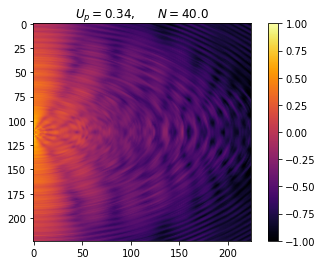

In [72]:
plt.imshow(PDFs_preprocessed[sample_idx, :, :, 0], cmap='inferno', vmin=-1, vmax=1)
plt.title(f"$U_p={labels[sample_idx, 0]}$,\t $N={labels[sample_idx, 1]}$")
plt.colorbar()
plt.show()

# Explainability

In [13]:
path = '../../public_dataset/explainability.npz'

In [14]:
npz = np.load(path)

In [15]:
npz.files

['analysis_grid_RGB', 'row_labels', 'col_labels', 'analysis_grid_raw']

In [16]:
analysis_grid_RGB = npz['analysis_grid_RGB']
analysis_grid_raw = npz['analysis_grid_raw']
row_labels = npz['row_labels']
col_labels = npz['col_labels']

`analysis_grid_RGB` are in the plottable RGB red-blue heatmap format used for paper. 

`analysis_grid_raw` has a raw representation of the analysis.

In [17]:
analysis_grid_RGB.shape  # (pictures, analyzers, image_size_1, image_size_2, colors)

(5, 12, 224, 224, 3)

In [18]:
analysis_grid_raw.shape # (pictures, analyzers, image_size_1, image_size_2)

(5, 12, 224, 224)

In [96]:
# Uncomment if you want to use latex fonts
# plt.rcParams.update({
#     "text.usetex": True,  # needs apt-get install cm-super
#     "font.family": 'STIXGeneral',  # "sans-serif",
#     "font.sans-serif": ["Helvetica"],
#     "font.size": 16,
#     'text.latex.preamble': r'\usepackage{amsfonts}\usepackage{physics}'  # for \mathbb
# })


In [19]:
# modified from https://github.com/albermax/innvestigate
def plot_image_grid(
    grid,
    row_labels_left,
    row_labels_right,
    col_labels,
    file_name=None,
    figsize=None,
    dpi=224,
):
    # TODO: reduce complexity

    n_rows = len(grid)
    n_cols = len(grid[0])
    if figsize is None:
        figsize = (n_cols, n_rows + 1)

    plt.clf()
    #plt.rc("font", family="sans-serif")

    fig=plt.figure(figsize=figsize)
    for r in range(n_rows):
        for c in range(n_cols):
            ax = plt.subplot2grid(shape=[n_rows + 1, n_cols], loc=[r + 1, c])
            # No border around subplots
            #for spine in ax.spines.values():
            #    spine.set_visible(False)
            # TODO controlled color mapping wrt all grid entries,
            # or individually. make input param
            if grid[r][c] is not None:
                ax.imshow(grid[r][c], interpolation="none")
            else:
                for spine in plt.gca().spines.values():
                    spine.set_visible(False)
            ax.set_xticks([])
            ax.set_yticks([])

            # column labels
            if not r:
                if len(col_labels) > 0:
                    ax.set_title(
                        col_labels[c],
                        rotation=22.5,
                        horizontalalignment="center",
                        verticalalignment="bottom",
                    )

            # row labels
            if not c:
                if len(row_labels_left) > 0:
                    txt_left = [label + "\n" for label in row_labels_left[r]]
                    ax.set_ylabel(
                        "".join(txt_left),
                        rotation=0,
                        verticalalignment="center",
                        horizontalalignment="right",
                    )

            if c == n_cols - 1:
                if len(row_labels_right) > 0:
                    txt_right = [label + "\n" for label in row_labels_right[r]]
                    ax2 = ax.twinx()
                    # No border around subplots
                    for spine in ax2.spines.values():
                        spine.set_visible(False)
                    ax2.set_xticks([])
                    ax2.set_yticks([])
                    ax2.set_ylabel(
                        "".join(txt_right),
                        rotation=0,
                        verticalalignment="center",
                        horizontalalignment="left",
                    )
    if file_name is None:
        plt.show()
    else:
        print(f"Saving figure to {file_name}")
        plt.savefig(file_name, orientation="landscape", dpi=dpi, bbox_inches="tight")
        plt.show()

<Figure size 432x288 with 0 Axes>

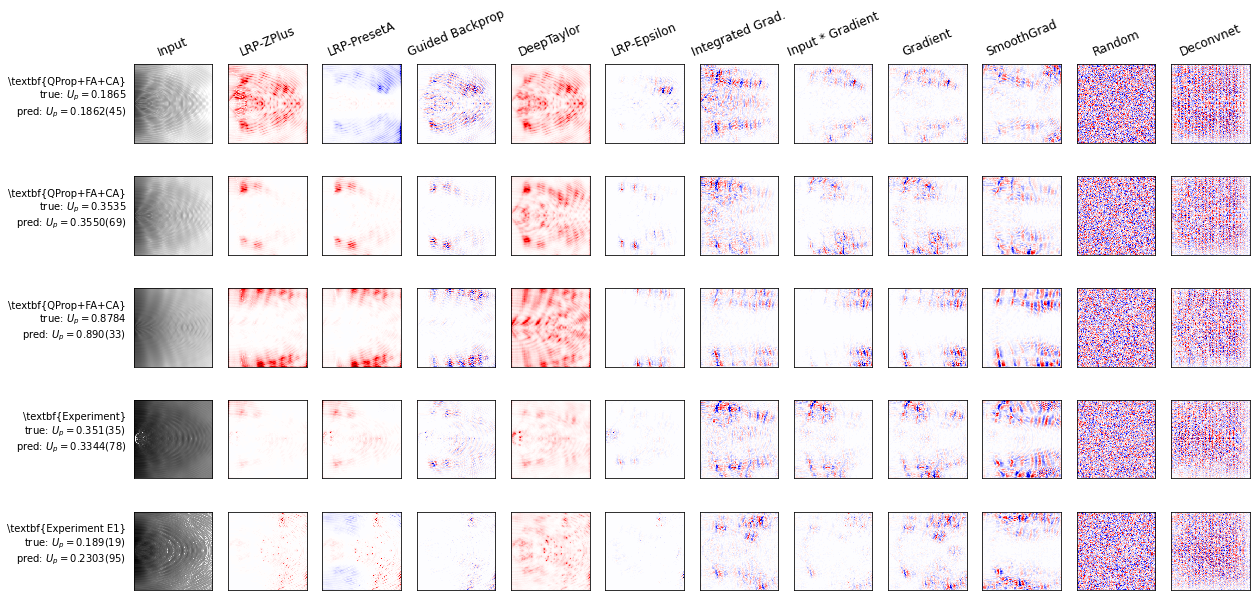

In [20]:
plot_image_grid(analysis_grid_RGB, row_labels, [], col_labels, file_name=None, figsize=(20,12))

Methods are ordered according to their AOPC score, from best (left) to worst (right). Values <0 are blue, values >0 are red.

How to simply read a specific method:

In [21]:
methods_cols = {}
for i, name in enumerate(col_labels):
    methods_cols[name] = i
methods_cols

{'Input': 0,
 'LRP-ZPlus': 1,
 'LRP-PresetA': 2,
 'Guided Backprop': 3,
 'DeepTaylor': 4,
 'LRP-Epsilon': 5,
 'Integrated Grad.': 6,
 'Input * Gradient': 7,
 'Gradient': 8,
 'SmoothGrad': 9,
 'Random': 10,
 'Deconvnet': 11}

LRP-ZPlus


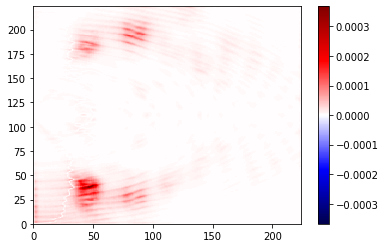

DeepTaylor


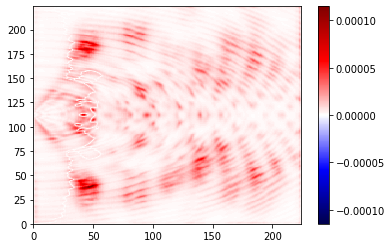

LRP-Epsilon


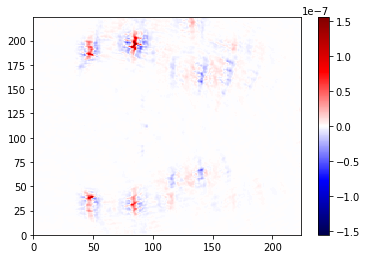

In [22]:
picture_idx = 1
methods = ['LRP-ZPlus', 'DeepTaylor', 'LRP-Epsilon']

for method in methods:
    print(method)
    analysis = analysis_grid_raw[picture_idx, methods_cols[method]]
    minval = np.min(analysis)
    maxval = np.max(analysis)
    scale_length = max((abs(minval), abs(maxval)))  # we want colorscale symmetric around zero
    
    plt.pcolormesh(analysis, cmap='seismic', vmin=-scale_length, vmax=scale_length)
    plt.colorbar()
    plt.show()